In [25]:
import pandapower as pp
import pandapower.plotting as plot
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import numpy as np
import warnings
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pandas as pd
from networkx.algorithms.bipartite.basic import color
from scipy.ndimage import label
from copy import deepcopy
from utils import run_time_series
from deap import base, creator, tools, algorithms
import multiprocessing
warnings.simplefilter(action="ignore", category=FutureWarning)

In [26]:
net = pp.create_empty_network()

# create buses
b1 = pp.create_bus(net, vn_kv=20.0, name="Bus 1")
bus= []
for i in range(17):
    b = pp.create_bus(net, vn_kv=0.4, name="Bus {i}")
    bus.append(b)
   
pp.create_ext_grid(net, bus=b1, vm_pu=1.02, name="Grid Connection")

tid = pp.create_transformer(
    net, hv_bus=b1, lv_bus=bus[0], std_type="0.4 MVA 20/0.4 kV", name="Trafo"
)
pp.create_load(net, bus=bus[0], p_mw=0.01, q_mvar=0.005, name="Load")
pp.create_sgen(net, bus=bus[0], p_mw=0.01, q_mvar=0.005, name="Load")

for y in range (1,8):
    pp.create_line(
        net, from_bus=bus[y-1], to_bus=bus[y], length_km=0.100, name="Line", std_type="NAYY 4x50 SE"
    )
    pp.create_load(net, bus=bus[y], p_mw=0.01, q_mvar=0.005, name="Load")
    pp.create_sgen(net, bus=bus[y], p_mw=0.01, q_mvar=0.005, name="Load")

pp.create_line(
        net, from_bus=bus[0], to_bus=bus[8], length_km=0.100, name="Line", std_type="NAYY 4x50 SE")
pp.create_load(net, bus=bus[8], p_mw=0.01, q_mvar=0.005, name="Load")
pp.create_sgen(net, bus=bus[8], p_mw=0.01, q_mvar=0.005, name="Load")


for j in range (9,17):
    pp.create_line(
        net, from_bus=bus[j-1], to_bus=bus[j], length_km=0.100, name="Line", std_type="NAYY 4x50 SE"
    )
    pp.create_load(net, bus=bus[j], p_mw=0.01, q_mvar=0.005, name="Load")
    pp.create_sgen(net, bus=bus[j], p_mw=0.01, q_mvar=0.005, name="Load")


# Initialisation Algorithm based on Correlation Matrix

In [27]:
Load = pd.read_csv("LoadData_B.csv", index_col=0, names=["Index"] + [f"Load_{i}" for i in range(1, 18)], header=0)
Generation = pd.read_csv("GenerationData_B.csv", index_col=0,
                         names=["Index"] + [f"Generation_{i}" for i in range(1, 18)], header=0)

Load_Profiles = pd.read_csv("LoadData_B.csv", index_col=0)
Gen_Profiles = pd.read_csv("generationData_B.csv", index_col=0)
best_results_per_iteration=[]
combined_df = pd.concat([Load, Generation], axis=1) 

# Step 2: Calculate the correlation matrix 
correlation_matrix = combined_df.corr()  

# Step 3: Extract the relevant part of the correlation matrix 
load_columns = Load.columns  
gen_columns = Generation.columns  

# Extract correlation between loads and generators
correlation_load_gen = correlation_matrix.loc[load_columns, gen_columns]

# Step 4: Find best pairs based on the correlation matrix
num_loads = len(load_columns)  
num_gens = len(gen_columns)  

assigned_gens = set()
assigned_loads = set()
best_pairs = {}

for load_index in range(num_loads):
    # Find the generator index with the highest correlation for this load, while avoiding already assigned generators
    load_corr_values = correlation_load_gen.iloc[load_index, :].values  
    available_gens = [i for i in range(num_gens) if i not in assigned_gens]  
    load_corr_values_filtered = load_corr_values[available_gens] 
    best_gen_index = available_gens[
        np.argmax(load_corr_values_filtered)]  

    # Assign the best generator to the load
    best_pairs[load_index] = best_gen_index
    assigned_loads.add(load_index)
    assigned_gens.add(best_gen_index)

# Step 5: Convert the best_pairs to a DataFrame 
best_pairs_df = pd.DataFrame(list(best_pairs.items()), columns=["Load", "Generator"])

# Set initial values for the optimization loop
Result = 100000
num_iter = 20
Best_load_indices_ia = []
Best_gen_indices_ia = []

# Step 6: Optimization loop
for count in range(num_iter):

    # Shuffle row wise to keep pairs intact
    Shuffeld = best_pairs_df.sample(frac=1)

    # Extract load and generator indices 
    generator_indices = Shuffeld["Generator"].to_list()
    load_indices = Shuffeld["Load"].to_list()

    # Calculate fitness (Buffer = sum of line loadings)
    Buffer = 0
    """"
    for hour in range(24):
        for i, load_id in enumerate(net.load.index):
            net.load.at[load_id, 'p_mw'] = Load.iloc[hour, load_indices[i]]

        for i, gen_id in enumerate(net.sgen.index):
            net.sgen.at[gen_id, 'p_mw'] = Generation.iloc[hour, generator_indices[i]]

        pp.runpp(net)
        Buffer += net.res_line['loading_percent'].max()
    """
    res_ext, res_lines = run_time_series(Gen_Profiles, Load_Profiles, net, generator_indices, load_indices,
                                         results_suffix="Initialisation_algorithm")

    Buffer = res_lines.max(axis=1).sum()

    # Check if current result is better than previous
    if Buffer < Result:
        Result = Buffer
        Best_load_indices_ia = load_indices
        Best_gen_indices_ia = generator_indices
    best_results_per_iteration.append(Result)     
# Output the best result
print(Result)
print("Load")
print(Best_load_indices_ia)

print("Generator")
print(Best_gen_indices_ia)


No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps

100%|██████████| 24/24 [00:00<00:00, 208.48it/s]
No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps

100%|██████████| 24/24 [00:00<00:00, 191.36it/s]
No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps

100%|██████████| 24/24 [00:00<00:00, 138.99it/s]
No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps

100%|██████████| 24/24 [00:00<00:00, 97.06it/s] 
No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps

100%|██████████| 24/24 [00:00<00:00, 89.66it/s]
No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps

100%|██████████| 24/24 [00:00<00:00, 87.24it/s] 
No ti

87.72918849502997
Load
[3, 0, 4, 13, 9, 7, 14, 8, 11, 1, 5, 15, 2, 6, 16, 12, 10]
Generator
[7, 8, 4, 12, 1, 9, 13, 3, 10, 5, 15, 11, 2, 0, 16, 14, 6]


# Random Assignment Algorithm

In [28]:
# Initialize variables
Result = 1000
num_iter = 20
Best_load_indices = []
Best_gen_indices = []
best_results_per_iteration_rand = []  # List to store the best result for each iteration
all_results_rand = []  # List to store the result (Buffer) for every iteration

# Optimization loop
for count in range(num_iter):
    # Shuffle generator and load indices independently
    generator_indices = list(best_pairs_df["Generator"].sample(frac=1).to_list())  # Shuffle generator indices
    load_indices = list(best_pairs_df["Load"].sample(frac=1).to_list())  # Shuffle load indices

    # Calculate fitness (Buffer = sum of line loadings)
    Buffer = 0

    # Use deepcopy of network for clean state
    network_copy = deepcopy(net)

    _, res_lines_initializer = run_time_series(
        Gen_Profiles, Load_Profiles, network_copy, generator_indices, load_indices, "Random_Initilisation"
    )
    max_value = res_lines_initializer.max(axis=1).sum()

    Buffer = max_value

    # Append the current result (Buffer) to the all_results list
    all_results_rand.append(Buffer)

    # Check if current result is better than previous
    if Buffer < Result:
        Result = Buffer
        Best_load_indices_rand = load_indices
        Best_gen_indices_rand = generator_indices

    # Append the best result of this iteration (Result) along with the associated indices
    best_results_per_iteration_rand.append(Result)

# Output the best result
print("\nBest found order and maximum loading value")
print(Result)
print("Generator order - ")
print(Best_gen_indices_rand)
print("Loading order - ")
print(Best_load_indices_rand)

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps

100%|██████████| 24/24 [00:00<00:00, 37.31it/s]
No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps

100%|██████████| 24/24 [00:00<00:00, 35.62it/s]
No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps

100%|██████████| 24/24 [00:00<00:00, 34.89it/s]
No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps

100%|██████████| 24/24 [00:00<00:00, 30.06it/s]
No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps

100%|██████████| 24/24 [00:00<00:00, 27.06it/s]
No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps

100%|██████████| 24/24 [00:01<00:00, 12.85it/s]
No time st


Best found order and maximum loading value
87.89824005984349
Generator order - 
[0, 3, 10, 7, 14, 2, 16, 15, 8, 5, 12, 4, 13, 11, 6, 1, 9]
Loading order - 
[3, 12, 2, 8, 13, 7, 15, 14, 10, 16, 6, 1, 11, 0, 4, 5, 9]


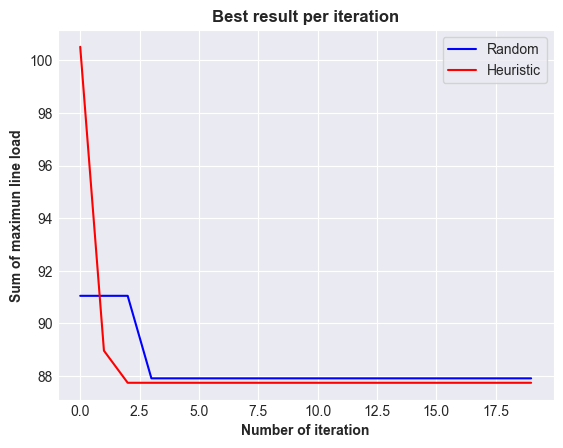

In [29]:
#Plot for comparision 
plt.plot(best_results_per_iteration_rand,label="Random",color="blue")
plt.plot(best_results_per_iteration,label="Heuristic",color="red")
plt.grid(True)                                         
# Add black box around the plot
plt.tick_params(axis='both', direction='in', length=5, width=1)
plt.xlabel("Number of iteration", fontweight='bold')     # Bold x-axis label
plt.ylabel("Sum of maximun line load", fontweight='bold')   
plt.title("Best result per iteration", fontweight='bold')
plt.legend()